In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import re
df = pd.read_csv('house_prices.csv')

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 187531 entries, 0 to 187530
Data columns (total 21 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Index              187531 non-null  int64  
 1   Title              187531 non-null  object 
 2   Description        184508 non-null  object 
 3   Amount(in rupees)  187531 non-null  object 
 4   Price (in rupees)  169866 non-null  float64
 5   location           187531 non-null  object 
 6   Carpet Area        106858 non-null  object 
 7   Status             186916 non-null  object 
 8   Floor              180454 non-null  object 
 9   Transaction        187448 non-null  object 
 10  Furnishing         184634 non-null  object 
 11  facing             117298 non-null  object 
 12  overlooking        106095 non-null  object 
 13  Society            77853 non-null   object 
 14  Bathroom           186703 non-null  object 
 15  Balcony            138596 non-null  object 
 16  Ca

In [3]:
df = df.rename(columns = {'Amount(in rupees)':'Amount','Price (in rupees)':'Price'})

In [4]:
df = df.drop(['Index','Dimensions','Plot Area','Society','Title','Description','Price','Super Area'],axis = 1)

In [5]:
df.isnull().sum()

Amount              0
location            0
Carpet Area     80673
Status            615
Floor            7077
Transaction        83
Furnishing       2897
facing          70233
overlooking     81436
Bathroom          828
Balcony         48935
Car Parking    103357
Ownership       65517
dtype: int64

In [6]:
df = df.dropna(subset=['Amount','Status','Floor','Furnishing','Bathroom','Transaction','Carpet Area'])
df['facing'] = df['facing'].fillna('Unknown')
df['overlooking'] = df['overlooking'].fillna('Not Available')
df['Ownership'] = df['Ownership'].fillna('Not Available')
df['Car Parking'] = df['Car Parking'].fillna('Not Available')
df['Balcony'] = df['Balcony'].fillna(0000)

In [7]:
df.isnull().sum()

Amount         0
location       0
Carpet Area    0
Status         0
Floor          0
Transaction    0
Furnishing     0
facing         0
overlooking    0
Bathroom       0
Balcony        0
Car Parking    0
Ownership      0
dtype: int64

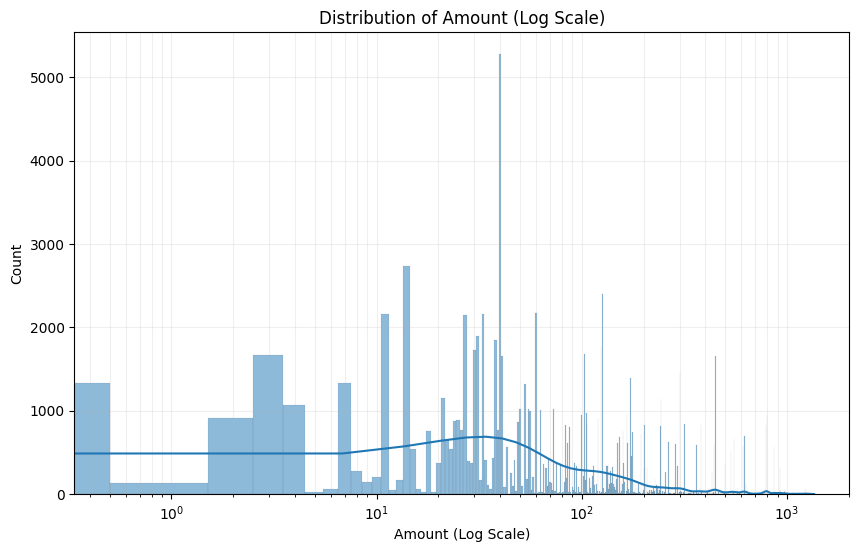

In [8]:
plt.figure(figsize=(10, 6))
# Use np.log1p to handle zero values gracefully (log(0) is undefined, log1p(x) = log(1+x))
# Filter out values that are too small for log scale to avoid warnings if they are negative or very close to zero and cause issues.
# A small epsilon is added to avoid log(0) if there are exact zeros that you don't want to transform to -inf.
# However, for log1p, it's generally safe with zeros.
sns.histplot(df['Amount'], bins=50, kde=True) # kde=True adds a density curve
plt.xscale('log') # Set the x-axis to a logarithmic scale
plt.title('Distribution of Amount (Log Scale)')
plt.xlabel('Amount (Log Scale)')
plt.ylabel('Count')
plt.grid(True, which="both", ls="-", alpha=0.2) # Add grid for better readability
plt.show()

----
As we can see that Amount column has datatype of object so we are converting it into numeric 
---
1:lac: which means lakh,So 98 Lac means 98 followed by five zeroes ,i.e replace lac with five zeroes

2 Cr: which means Crore,So 1.98 Cr means 1.98 followed by five zeroes ,i.e replace Cr with five zeroes

In [9]:
def parse_amount(amount_str):
    amount_str = str(amount_str).strip().lower().replace(" ", "") # Clean string
    
    if 'lac' in amount_str:
        num_part = amount_str.replace('lac', '')
        try:
            return float(num_part) * 100000
        except ValueError:
            return np.nan # Or handle specific error, e.g., print a warning
    elif 'cr' in amount_str:
        num_part = amount_str.replace('cr', '')
        try:
            return float(num_part) * 10000000 # 1 Crore = 100 Lakhs = 10,000,000
        except ValueError:
            return np.nan
    else:
        # Assume it's already a plain number
        try:
            return float(amount_str)
        except ValueError:
            return np.nan # Handle cases where it's not a recognizable number

# Applying  the function to the 'Amount' column
df['Amount_Cleaned'] = df['Amount'].apply(parse_amount)

#Replacing the original 'Amount' Column
df['Amount'] = df['Amount_Cleaned']
df = df.drop(columns=['Amount_Cleaned']) # Droping the temporary column


----
Converting the carpet area into the format of sqft i.e to numeric value
----

In [10]:
CONVERSION_FACTORS = {
    'sqft': 1,
    'sqyrd': 9,       # 1 Square Yard = 9 Square Feet
    'sqm': 10.764,    # 1 Square Meter = 10.764 Square Feet (approx)
    'kanal': 4500,    # Common in parts of Punjab, Haryana, HP (India)
                      # Alternative: 5445 sqft (common in Pakistan/some older Indian contexts)
    'acre': 43560,    # 1 Acre = 43560 Square Feet
    'marla': 272.25,  # Standard Marla, approx. 1/160th of an Acre
                      # Alternative: 225 sqft (common in some urban areas like Lahore)
    'hectare': 107639.104 # 1 Hectare = 107639.104 Square Feet (approx)
}

def convert_area_to_sqft(area_str):
    if pd.isna(area_str) or not isinstance(area_str, str) or not area_str.strip():
        return np.nan # Return NaN for NaN, non-string, or empty strings

    area_str_clean = area_str.strip().lower() # Clean and standardize case

    # Regular expression to extract number and unit
    # This regex looks for:
    # (\d+\.?\d*): one or more digits, optionally followed by a dot and more digits (for decimals)
    # \s*: zero or more whitespace characters
    # ([a-z.]+): one or more letters, allowing for periods (e.g., 'sq.m', 'sq.yd')
    match = re.match(r'(\d+\.?\d*)\s*([a-z.]+)', area_str_clean)

    if match:
        value = float(match.group(1))
        unit = match.group(2).replace('.', '') # Remove periods from unit (e.g., 'sq.m' -> 'sqm')

        if unit in CONVERSION_FACTORS:
            return value * CONVERSION_FACTORS[unit]
        else:
            # print(f"Warning: Unknown unit '{unit}' found for value '{area_str}'. Returning NaN.")
            return np.nan # Return NaN for unknown units
    else:
        # If no unit is found, try to convert the string directly to float.
        # This handles cases where only a number (assumed to be sqft) is present.
        try:
            return float(area_str_clean)
        except ValueError:
            # print(f"Warning: Could not parse '{area_str}'. Returning NaN.")
            return np.nan # Return NaN for strings that are not numbers or recognized units

# --- 4. Apply the Conversion Function to Relevant Columns ---
column_to_convert = ['Carpet Area']

for col in column_to_convert:
    # Create new columns with '_sqft' suffix
    df[f'{col}_sqft'] = df[col].apply(convert_area_to_sqft)

# --- 5.Dropping Original Columns ---
df = df.drop(columns=column_to_convert)

---
Created two different columns for covered and opened for parking
---

In [11]:
import pandas as pd
import numpy as np
import re

def parse_parking_details(parking_str):
    parking_type = 'Not Available' # Default for NaN/unparseable

    # Handle NaN, non-string, or empty strings
    if pd.isna(parking_str) or not isinstance(parking_str, str) or not parking_str.strip():
        return parking_type # Return default 'Not Available'

    parking_str = parking_str.strip().lower().replace(',', '') # Clean and standardize

    # Check for 'not available' first
    if parking_str == 'not available':
        return 'Not Available'

    # Regex to find number and type (e.g., "10 covered", "5 open")
    # We are still using the regex to identify 'covered' or 'open' types,
    # even if we don't extract the count.
    match = re.search(r'(\d+)\s*(covered|open)', parking_str)
    if match:
        type_str = match.group(2)     # Extract the type ('covered' or 'open')
        return type_str.capitalize() # Capitalize the type (e.g., 'Covered')

    # If no specific pattern matched, it's an unhandled case.
    # In this scenario, we return the default 'Not Available' type.
    return 'Not Available'

# Apply the parsing function to create only the 'parking_type' column
# Since parse_parking_details now returns a single value, pd.Series is not needed here.
df['parking_type'] = df['Car Parking'].apply(parse_parking_details)

# Drop the original 'Car Parking' column as it's no longer needed
df = df.drop('Car Parking', axis=1)



-----
Converting the floor into numeric data type
----

In [12]:
# Function to extract flat_floor and total_floors
def parse_floor_info(floor_str):
    flat_floor = np.nan
    total_floors = np.nan

    if pd.isna(floor_str) or not isinstance(floor_str, str) or not floor_str.strip():
        return flat_floor, total_floors # Return NaNs for invalid/missing strings

    floor_str = floor_str.strip().lower()

    # --- 1. Handle "X out of Y" patterns (most common in your data) ---
    # Matches "number out of number"
    match_num_out_of_num = re.match(r'(\d+)\s*out of\s*(\d+)', floor_str)
    if match_num_out_of_num:
        flat_floor = float(match_num_out_of_num.group(1))
        total_floors = float(match_num_out_of_num.group(2))
        return flat_floor, total_floors

    # Matches "ground out of number"
    match_ground_out_of_num = re.match(r'ground\s*out of\s*(\d+)', floor_str)
    if match_ground_out_of_num:
        flat_floor = 0.0 # Ground floor
        total_floors = float(match_ground_out_of_num.group(1))
        return flat_floor, total_floors

    # Matches "upper basement out of number"
    match_ub_out_of_num = re.match(r'upper basement\s*out of\s*(\d+)', floor_str)
    if match_ub_out_of_num:
        flat_floor = -1.0 # Upper basement
        total_floors = float(match_ub_out_of_num.group(1))
        return flat_floor, total_floors

    # Matches "lower basement out of number"
    match_lb_out_of_num = re.match(r'lower basement\s*out of\s*(\d+)', floor_str)
    if match_lb_out_of_num:
        flat_floor = -2.0 # Lower basement
        total_floors = float(match_lb_out_of_num.group(1))
        return flat_floor, total_floors

    # --- 2. Handle standalone textual descriptions (without "out of Y") ---
    if floor_str in ['ground floor', 'ground', 'g']:
        flat_floor = 0.0
        # total_floors remains NaN as it's not specified
        return flat_floor, total_floors
    elif floor_str in ['first floor', 'first', '1st']:
        flat_floor = 1.0
        return flat_floor, total_floors
    elif floor_str in ['second floor', 'second', '2nd']:
        flat_floor = 2.0
        return flat_floor, total_floors
    elif floor_str in ['basement', 'b', 'upper basement', 'lower basement']:
        # If no "out of Y" given, default basement to -1.0
        # You could refine this to -1.0 for UB, -2.0 for LB if they appear standalone.
        flat_floor = -1.0
        return flat_floor, total_floors

    # --- 3. Handle 'Top Floor', 'Penthouse', 'Multiple Floors' (ambiguous for numbers) ---
    if floor_str in ['top floor', 'penthouse', 'multiple floors', 'duplex', 'triplex']:
        # Both remain NaN as it's hard to assign specific numbers reliably
        return flat_floor, total_floors

    # --- 4. Handle simple numbers (e.g., '2', '10') ---
    try:
        flat_floor = float(floor_str)
        # total_floors remains NaN
        return flat_floor, total_floors
    except ValueError:
        pass # Not a simple number, continue to regex attempts

    # --- 5. Handle ranges like "3-5" (less common but good to keep) ---
    if '-' in floor_str:
        parts = floor_str.split('-')
        if len(parts) == 2 and parts[0].isdigit() and parts[1].isdigit():
            flat_floor = (float(parts[0]) + float(parts[1])) / 2.0
            # total_floors remains NaN
            return flat_floor, total_floors

    # --- 6. Final fallback: If nothing matched, return NaN for both ---
    # print(f"Warning: Could not parse '{floor_str}'. Returning NaN for both floor numbers.") # Uncomment for debugging
    return np.nan, np.nan

# Apply the parsing function and assign to new columns
df[['flat_floor', 'total_floors']] = df['Floor'].apply(lambda x: pd.Series(parse_floor_info(x)))
df = df.drop('Floor',axis=1)
print(df.columns)

Index(['Amount', 'location', 'Status', 'Transaction', 'Furnishing', 'facing',
       'overlooking', 'Bathroom', 'Balcony', 'Ownership', 'Carpet Area_sqft',
       'parking_type', 'flat_floor', 'total_floors'],
      dtype='object')


----
Cleaning the duplicates that is showing the same categories but the words mixed up
---

In [13]:
df['overlooking'] = df['overlooking'].replace({'Pool, Garden/Park, Main Road':'Garden/Park, Pool, Main Road',
                                              'Main Road, Garden/Park':'Garden/Park, Main Road',
                                              'Main Road, Garden/Park, Pool':'Garden/Park, Pool, Main Road',
                                              'Pool, Garden/Park':'Garden/Park, Pool',
                                              'Garden/Park, Main Road, Pool':'Garden/Park, Pool, Main Road',
                                              'Main Road, Pool, Garden/Park':'Garden/Park, Pool, Main Road',
                                              'Pool, Main Road, Garden/Park':'Garden/Park, Pool, Main Road',
                                              'Main Road, Pool':'Pool, Main Road'})

In [14]:
df['overlooking'].unique()

array(['Not Available', 'Garden/Park', 'Garden/Park, Main Road',
       'Main Road', 'Garden/Park, Pool, Main Road', 'Garden/Park, Pool',
       'Pool', 'Pool, Main Road', 'Main Road, Not Available',
       'Garden/Park, Pool, Main Road, Not Available',
       'Garden/Park, Not Available'], dtype=object)

In [15]:
def clean_Bathroom_count(Bathroom_str):
    if pd.isna(Bathroom_str) or not isinstance(Bathroom_str, str):
        return np.nan

    Bathroom_str_lower = Bathroom_str.strip().lower()

    if Bathroom_str_lower == 'not available':
        return np.nan
    elif Bathroom_str_lower == '> 10': # If this value exists, handle it
        return 11.0 # return 11.0
    else:
        try:
            return float(Bathroom_str_lower)
        except ValueError:
            # Handle other potential non-numeric strings if they appear
            return np.nan

df['Bathroom_numeric'] = df['Bathroom'].apply(clean_Bathroom_count)
print("\n'Bathroom_numeric' unique values after initial cleaning and NaNs:")
print(df['Bathroom_numeric'].value_counts(dropna=False).sort_index())

df = df.drop('Bathroom',axis=1)


'Bathroom_numeric' unique values after initial cleaning and NaNs:
Bathroom_numeric
1.0      9804
2.0     49412
3.0     31583
4.0     10663
5.0      2829
6.0       112
7.0        18
8.0         4
9.0         4
10.0        6
11.0       12
Name: count, dtype: int64


In [16]:
def clean_balcony_count(balcony_str):
    if pd.isna(balcony_str) or not isinstance(balcony_str, str):
        return np.nan

    balcony_str_lower = balcony_str.strip().lower()

    if balcony_str_lower == 'not available':
        return np.nan
    elif balcony_str_lower == '> 10': # If this value exists, handle it
        return 11.0 # Let KNN impute, or return 11.0
    else:
        try:
            return float(balcony_str_lower)
        except ValueError:
            # Handle other potential non-numeric strings if they appear
            return np.nan

df['Balcony_numeric'] = df['Balcony'].apply(clean_balcony_count)
print("\n'Balcony_numeric' unique values after initial cleaning and NaNs:")
print(df['Balcony_numeric'].value_counts(dropna=False).sort_index())

df = df.drop('Balcony',axis=1)


'Balcony_numeric' unique values after initial cleaning and NaNs:
Balcony_numeric
1.0     32792
2.0     37744
3.0     18532
4.0      8426
5.0       534
6.0        81
7.0        10
8.0         8
9.0         2
10.0        8
11.0        8
NaN      6302
Name: count, dtype: int64


In [17]:
df.isnull().sum()

Amount              5278
location               0
Status                 0
Transaction            0
Furnishing             0
facing                 0
overlooking            0
Ownership              0
Carpet Area_sqft       3
parking_type           0
flat_floor             0
total_floors           5
Bathroom_numeric       0
Balcony_numeric     6302
dtype: int64

In [18]:
df = df.dropna(subset = ['Amount','Balcony_numeric','total_floors','Carpet Area_sqft'])


In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 93261 entries, 0 to 187528
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Amount            93261 non-null  float64
 1   location          93261 non-null  object 
 2   Status            93261 non-null  object 
 3   Transaction       93261 non-null  object 
 4   Furnishing        93261 non-null  object 
 5   facing            93261 non-null  object 
 6   overlooking       93261 non-null  object 
 7   Ownership         93261 non-null  object 
 8   Carpet Area_sqft  93261 non-null  float64
 9   parking_type      93261 non-null  object 
 10  flat_floor        93261 non-null  float64
 11  total_floors      93261 non-null  float64
 12  Bathroom_numeric  93261 non-null  float64
 13  Balcony_numeric   93261 non-null  float64
dtypes: float64(6), object(8)
memory usage: 10.7+ MB


In [20]:
df = df.rename(columns={'Bathroom_numeric':'Bathrooms','Balcony_numeric':'Balcony','flat_floor':'Flat_floor','total_floors':'Total_floors',
                       'location':'Location','facing':'Facing','Carpet Area_sqft':'Carpet_Area','parking_type':'Parking_type'})

In [23]:
df.columns

Index(['Amount', 'Location', 'Status', 'Transaction', 'Furnishing', 'Facing',
       'overlooking', 'Ownership', 'Carpet_Area', 'Parking_type', 'Flat_floor',
       'Total_floors', 'Bathrooms', 'Balcony'],
      dtype='object')

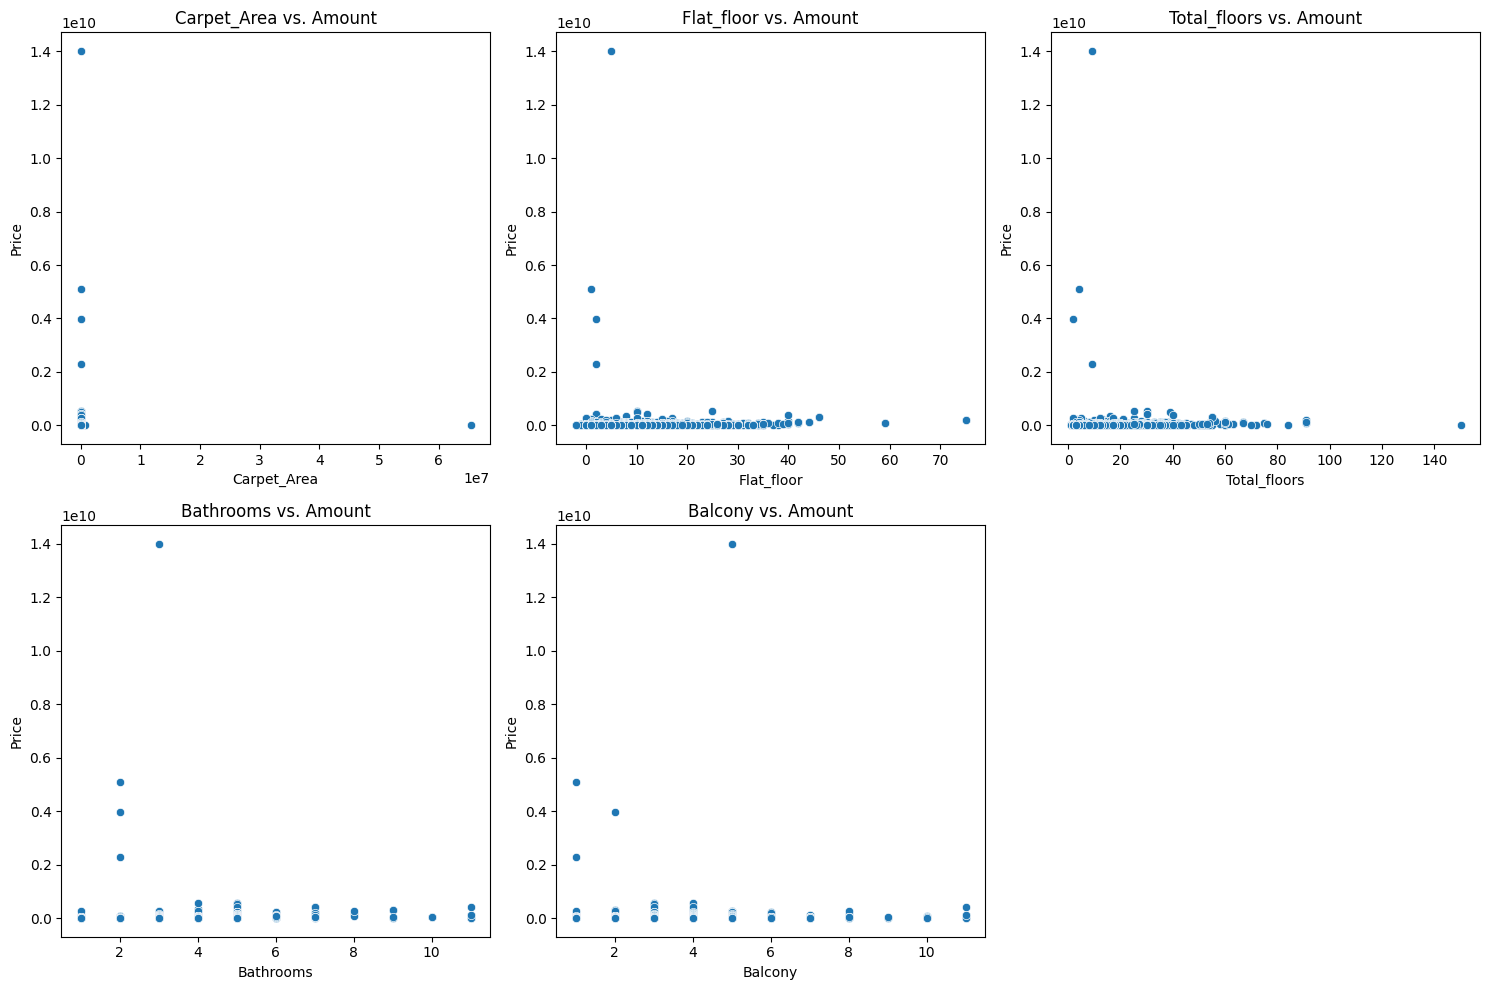

In [24]:
numerical_cols = ['Carpet_Area', 'Flat_floor', 'Total_floors', 'Bathrooms', 'Balcony']

plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_cols):
    plt.subplot(2, 3, i + 1) # Adjust subplot grid as needed
    sns.scatterplot(x=col, y='Amount', data=df)
    plt.title(f'{col} vs. Amount')
    plt.xlabel(col)
    plt.ylabel('Price')
plt.tight_layout()
plt.show()

In [32]:
columns_to_check = ['Carpet_Area', 'Flat_floor', 'Total_floors', 'Bathrooms', 'Balcony']

# Initialize a boolean mask to keep track of rows that are NOT outliers
# Start with all rows as True (meaning, keep them initially)
non_outlier_mask = pd.Series(True, index=df.index)

for col in columns_to_check:
    print(f"\n--- Processing column: {col} ---")

    # Calculate Q1 (25th percentile)
    Q1 = df[col].quantile(0.25)
    print(f"Q1 ({col}): {Q1}")

    # Calculate Q3 (75th percentile)
    Q3 = df[col].quantile(0.75)
    print(f"Q3 ({col}): {Q3}")

    # Calculate IQR
    IQR = Q3 - Q1
    print(f"IQR ({col}): {IQR}")

    # Define the upper and lower bounds for outlier detection
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    print(f"Lower Bound ({col}): {lower_bound}")
    print(f"Upper Bound ({col}): {upper_bound}")

    # Identify outliers for the current column
    # This mask is True for outliers in the current column
    current_col_outliers_mask = (df[col] < lower_bound) | (df[col] > upper_bound)
    num_outliers_in_col = current_col_outliers_mask.sum()
    print(f"Number of outliers in {col}: {num_outliers_in_col}")

    if num_outliers_in_col > 0:
        print(f"Outliers in {col} (sample):\n{df[current_col_outliers_mask][[col]].head()}")
        # Update the overall non_outlier_mask:
        # A row is considered a non-outlier overall ONLY IF it's not an outlier in THIS column AND
        # it wasn't an outlier in any previous columns.
        non_outlier_mask = non_outlier_mask & (~current_col_outliers_mask)
    else:
        print(f"No outliers found in {col} using the 1.5*IQR rule.")

# --- Remove the identified outliers from the DataFrame ---
# Filter the DataFrame to keep only the rows where non_outlier_mask is True
df = df[non_outlier_mask].copy() # .copy() to ensure it's a new DataFrame




--- Processing column: Carpet_Area ---
Q1 (Carpet_Area): 850.0
Q3 (Carpet_Area): 1500.0
IQR (Carpet_Area): 650.0
Lower Bound (Carpet_Area): -125.0
Upper Bound (Carpet_Area): 2475.0
Number of outliers in Carpet_Area: 864
Outliers in Carpet_Area (sample):
      Carpet_Area
2865       2531.0
2973       2532.0
3075       2600.0
3406       2565.0
3537       2600.0

--- Processing column: Flat_floor ---
Q1 (Flat_floor): 2.0
Q3 (Flat_floor): 5.0
IQR (Flat_floor): 3.0
Lower Bound (Flat_floor): -2.5
Upper Bound (Flat_floor): 9.5
Number of outliers in Flat_floor: 5599
Outliers in Flat_floor (sample):
     Flat_floor
0          10.0
15         10.0
54         10.0
110        10.0
142        10.0

--- Processing column: Total_floors ---
Q1 (Total_floors): 4.0
Q3 (Total_floors): 10.0
IQR (Total_floors): 6.0
Lower Bound (Total_floors): -5.0
Upper Bound (Total_floors): 19.0
Number of outliers in Total_floors: 3608
Outliers in Total_floors (sample):
     Total_floors
28           20.0
29           24

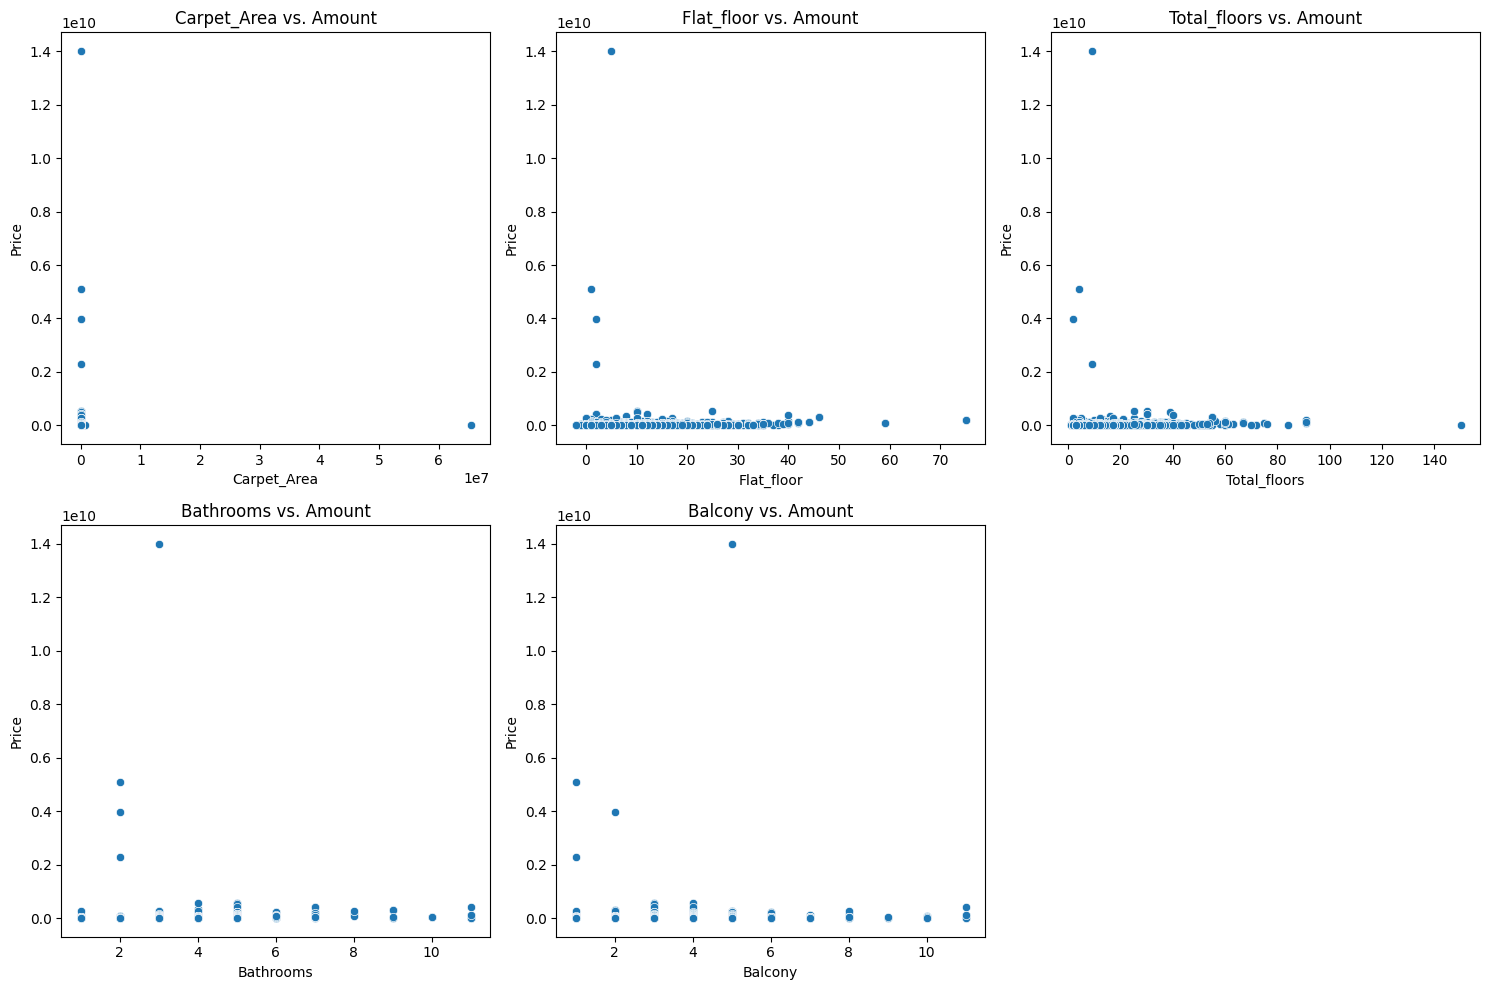

In [27]:
numerical_cols = ['Carpet_Area', 'Flat_floor', 'Total_floors', 'Bathrooms', 'Balcony']

plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_cols):
    plt.subplot(2, 3, i + 1) # Adjust subplot grid as needed
    sns.scatterplot(x=col, y='Amount', data=df)
    plt.title(f'{col} vs. Amount')
    plt.xlabel(col)
    plt.ylabel('Price')
plt.tight_layout()
plt.show()

In [33]:
import pandas as pd

columns_to_onehot = [
    'Location',
    'Transaction',
    'Furnishing',
    'Facing',
    'overlooking', # Note: Using the exact column name from your unique values
    'Ownership',
    'Parking_type'
]

# Apply one-hot encoding
df_encoded = pd.get_dummies(df, columns=columns_to_onehot, drop_first=False)
# drop_first=False is often used to keep all categories, but for preventing multicollinearity,
# drop_first=True is sometimes preferred, dropping one category per feature.
# The choice depends on the specific model and context.

# Drop the 'Status' column as it has only one unique value
df_encoded = df_encoded.drop('Status', axis=1)

# The original columns will be replaced by new binary columns (e.g., 'Location_thane', 'Location_nagpur', etc.)
df_encoded.columns

Index(['Amount', 'Carpet_Area', 'Flat_floor', 'Total_floors', 'Bathrooms',
       'Balcony', 'Location_agra', 'Location_ahmadnagar', 'Location_ahmedabad',
       'Location_allahabad',
       ...
       'overlooking_Pool', 'overlooking_Pool, Main Road',
       'Ownership_Co-operative Society', 'Ownership_Freehold',
       'Ownership_Leasehold', 'Ownership_Not Available',
       'Ownership_Power Of Attorney', 'Parking_type_Covered',
       'Parking_type_Not Available', 'Parking_type_Open'],
      dtype='object', length=120)

In [34]:
df_encoded.shape

(73523, 120)

Mean Squared Error (MSE): 51238514335005.26
Mean Absolute Error (MAE): 4125570.03
R-squared (R2 Score): 0.35


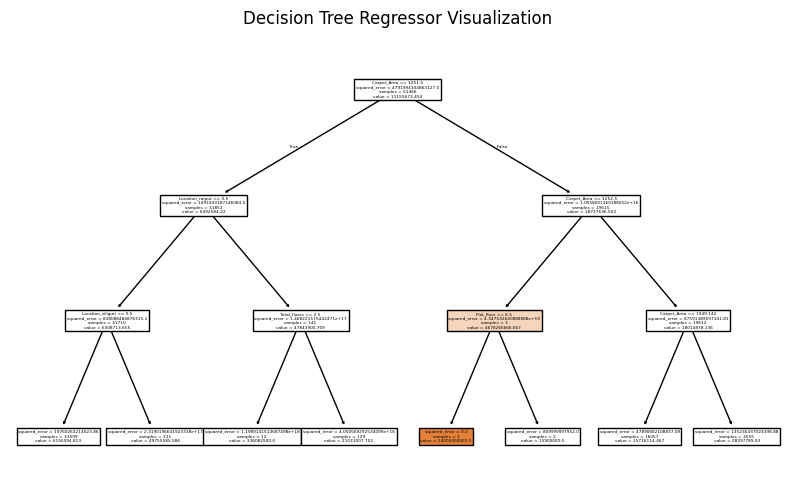

In [44]:
# Import required libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

# Separate features and target
X = df_encoded.drop(columns='Amount')
y = df_encoded['Amount']

# Split data into training and testing sets (70% train, 30% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initialize Decision Tree Regressor
model = DecisionTreeRegressor(max_depth=3, random_state=42)

# Train the model
model.fit(X_train, y_train)

# Predict on test set
y_pred = model.predict(X_test)

# Evaluate model performance with regression metrics
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"R-squared (R2 Score): {r2:.2f}")

# Visualize the Decision Tree
plt.figure(figsize=(10, 6))
plot_tree(model, feature_names=X.columns, filled=True)
plt.title('Decision Tree Regressor Visualization')
plt.show()



Mean Squared Error (MSE): 37094798507720.70
Mean Absolute Error (MAE): 3926030.46
R-squared (R2 Score): 0.53


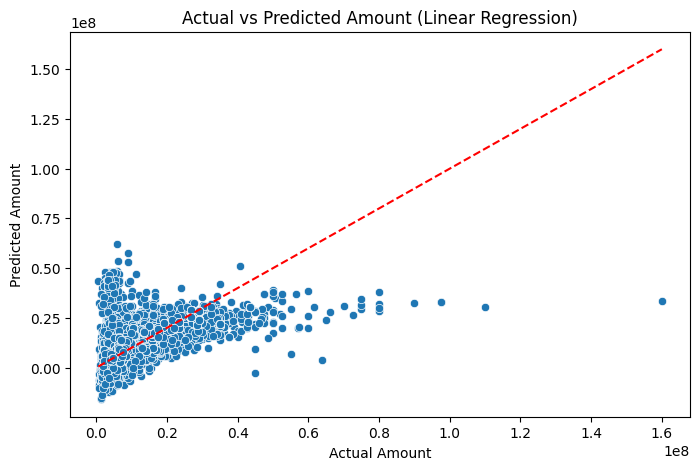

In [45]:
# Import required libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns


# Separate features and target
X = df_encoded.drop(columns='Amount')
y = df_encoded['Amount']


# Split data into training and testing sets (70% train, 30% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initialize Linear Regression model
model = LinearRegression()

# Train the model
model.fit(X_train, y_train)

# Predict on test set
y_pred = model.predict(X_test)

# Evaluate model performance
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"R-squared (R2 Score): {r2:.2f}")

# Optional: Visualize actual vs predicted values
plt.figure(figsize=(8, 5))
sns.scatterplot(x=y_test, y=y_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # 45-degree line
plt.xlabel('Actual Amount')
plt.ylabel('Predicted Amount')
plt.title('Actual vs Predicted Amount (Linear Regression)')
plt.show()
